<a href="https://colab.research.google.com/github/esraamosalman22-arch/ml_final_project-_E.J/blob/main/regression_project_esra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [ ]:
orders = pd.read_csv("orders.csv")
prior = pd.read_csv("order_products__prior.csv")


In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
# حذف أول طلب
orders = orders.dropna(subset=["days_since_prior_order"]) #احذف الصفوف الفارغة

# عدد الطلبات لكل مستخدم
user_orders = orders.groupby("user_id").agg(  #بنجمع كل الطلبات وبنحسب اعلى  قيمة
    total_orders=("order_number", "max")
).reset_index()

# عدد المنتجات وإعادة الشراء لكل طلب
user_products = prior.groupby("order_id").agg( #بنجمع كل المنتجات على  حسب الطلب
    products_per_order=("product_id", "count"),
    reorder_count=("reordered", "sum")
).reset_index()

# دمج
df = orders.merge(user_products, on="order_id", how="left")
df = df.merge(user_orders, on="user_id", how="left")

# تجميع على مستوى المستخدم
df = df.groupby("user_id").agg(
    avg_products_per_order=("products_per_order", "mean"), #نعيد التجميع على حسب المستخدم وليس الطلب
    avg_reorder_count=("reorder_count", "mean"),#متوسط عدد المنتجات المعاد شراؤها لكل طلب
    total_orders=("total_orders", "max"),#اجمالي عدد الطلبات لكل مستخدم
    target_days=("days_since_prior_order", "mean") #متوسط الأيام بين الطلبات (هذا الهدف للتنبؤ)
).reset_index()


In [ ]:
#feature engeniring
# كثافة إعادة الشراء
df["reorder_ratio"] = df["avg_reorder_count"] / (df["avg_products_per_order"] + 1) #نسبة المنتجات التي يعيد المستخدم شراؤها

# مستخدم ثقيل / متكرر
df["is_heavy_user"] = (df["avg_products_per_order"] > df["avg_products_per_order"].median()).astype(int)#مستخدم ثقيل (heavy user) → عادة يشتري عدد كبير من المنتجات
df["is_frequent_user"] = (df["total_orders"] > df["total_orders"].median()).astype(int)#تصنيف المستخدمين حسب كمية الطلبات الكلية:

# Bulk buyer    يشترون كمية كبيرة من المنتجات لكن لا يعيدون شراؤها كثيرًا(يشتروا بالجملة )
df["bulk_buyer"] = (
    (df["avg_products_per_order"] > 8) &
    (df["reorder_ratio"] < 0.4)
).astype(int)


In [ ]:
#feature engeniring
#تنوع المنتجات
prior_user = prior.merge(
    orders[["order_id", "user_id"]],
    on="order_id",
    how="left"
)

unique_products = (
    prior_user.groupby("user_id")["product_id"]
    .nunique()
)

df["unique_products"] = df["user_id"].map(unique_products) #عدد المنتجات المختلفة
df["unique_products"].fillna(0, inplace=True)



# انتظام المستخدم  قياس انتظام المستخدم في الطلبات
df["median_days_between_orders"] = (
    orders.groupby("user_id")["days_since_prior_order"].median().values
)

df["std_days_between_orders"] = (
    orders.groupby("user_id")["days_since_prior_order"].std().values
)

# معامل الانتظام  تباين الأيام بين الطلبات
df["days_cv"] = (
    df["std_days_between_orders"] /
    (df["median_days_between_orders"] + 1)
)

#معرفة متوسط عدد الأيام بين الطلبات في آخر 3 طلبات لكل مستخدم
recent_orders = (
    orders.sort_values(["user_id", "order_number"])
    .groupby("user_id")
    .tail(3)
)

recent_days = recent_orders.groupby("user_id")["days_since_prior_order"].mean()

df["recent_avg_days"] = df["user_id"].map(recent_days)

# لو مستخدم عنده طلبات قليلة
df["recent_avg_days"].fillna(
    df["median_days_between_orders"],
    inplace=True
)

#الفرق بين السلوك الحديث والسلوك العام لكل مستخدم.
df["recent_vs_overall"] = (
    df["recent_avg_days"] /
    (df["median_days_between_orders"] + 1)
)

df["orders_x_reorder"] = (
    df["total_orders"] * df["reorder_ratio"]
)


/tmp/ipython-input-1342299556.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["unique_products"].fillna(0, inplace=True)
/tmp/ipython-input-1342299556.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [ ]:
df.shape[1]

16

In [ ]:
df.columns

Index(['user_id', 'avg_products_per_order', 'avg_reorder_count',
       'total_orders', 'target_days', 'reorder_ratio', 'is_heavy_user',
       'is_frequent_user', 'bulk_buyer', 'unique_products',
       'median_days_between_orders', 'std_days_between_orders', 'days_cv',
       'recent_avg_days', 'recent_vs_overall', 'orders_x_reorder'],
      dtype='object')

In [ ]:

df.head()

,user_id,avg_products_per_order,avg_reorder_count,total_orders,target_days,reorder_ratio,is_heavy_user,is_frequent_user,bulk_buyer,unique_products,median_days_between_orders,std_days_between_orders,days_cv,recent_avg_days,recent_vs_overall,orders_x_reorder
0,1,6.000000,4.555556,11,19.000000,0.650794,0,1,0,17,19.5,9.030811,0.440527,14.666667,0.715447,7.158730
1,2,14.000000,7.153846,15,16.285714,0.476923,1,1,0,99,13.0,10.268912,0.733494,24.333333,1.738095,7.153846
2,3,7.090909,5.000000,13,12.000000,0.617978,0,1,0,31,11.0,5.134553,0.427879,12.333333,1.027778,8.033708
3,4,3.500000,0.250000,6,17.000000,0.055556,0,0,0,14,19.0,10.977249,0.548862,15.000000,0.750000,0.333333
4,5,8.666667,4.666667,5,11.500000,0.482759,0,0,0,18,10.5,5.446712,0.473627,11.666667,1.014493,2.413793


In [ ]:
print(df.shape)
df.head()


(206209, 16)


,user_id,avg_products_per_order,avg_reorder_count,total_orders,target_days,reorder_ratio,is_heavy_user,is_frequent_user,bulk_buyer,unique_products,median_days_between_orders,std_days_between_orders,days_cv,recent_avg_days,recent_vs_overall,orders_x_reorder
0,1,6.000000,4.555556,11,19.000000,0.650794,0,1,0,17,19.5,9.030811,0.440527,14.666667,0.715447,7.158730
1,2,14.000000,7.153846,15,16.285714,0.476923,1,1,0,99,13.0,10.268912,0.733494,24.333333,1.738095,7.153846
2,3,7.090909,5.000000,13,12.000000,0.617978,0,1,0,31,11.0,5.134553,0.427879,12.333333,1.027778,8.033708
3,4,3.500000,0.250000,6,17.000000,0.055556,0,0,0,14,19.0,10.977249,0.548862,15.000000,0.750000,0.333333
4,5,8.666667,4.666667,5,11.500000,0.482759,0,0,0,18,10.5,5.446712,0.473627,11.666667,1.014493,2.413793


In [ ]:
df.isnull().sum()

,0
user_id,0
avg_products_per_order,0
avg_reorder_count,0
total_orders,0
target_days,0
reorder_ratio,0
is_heavy_user,0
is_frequent_user,0
bulk_buyer,0
unique_products,0


In [ ]:
X = df.drop(["target_days"], axis=1)
y = df["target_days"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# 2. حساب VIF قبل التدريب
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

X = X.select_dtypes(include=[float, int])
X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

                       Feature        VIF
0                        const  61.059784
1                      user_id   1.000043
2       avg_products_per_order  12.066491
3            avg_reorder_count  18.076365
4                 total_orders  48.671249
5                reorder_ratio   5.754504
6                is_heavy_user   2.809766
7             is_frequent_user   2.427542
8                   bulk_buyer   2.257010
9              unique_products   5.413465
10  median_days_between_orders   9.845911
11     std_days_between_orders   1.726168
12                     days_cv   3.277582
13             recent_avg_days  10.245386
14           recent_vs_overall   5.075363
15            orders_x_reorder  41.246623


In [ ]:
#تم اكتشاف انه فيها multicolineriality (avg_recorder_count)drop



# 6️⃣ إزالة multicollinearity / Features غير مهمة
df.drop(["user_id", "avg_reorder_count", "total_orders", "orders_x_reorder",
         "median_days_between_orders", "recent_vs_overall"], axis=1, inplace=True)

In [ ]:
df.columns

Index(['avg_products_per_order', 'target_days', 'reorder_ratio',
       'is_heavy_user', 'is_frequent_user', 'bulk_buyer', 'unique_products',
       'std_days_between_orders', 'days_cv', 'recent_avg_days'],
      dtype='object')

In [ ]:
df.shape[1]

10

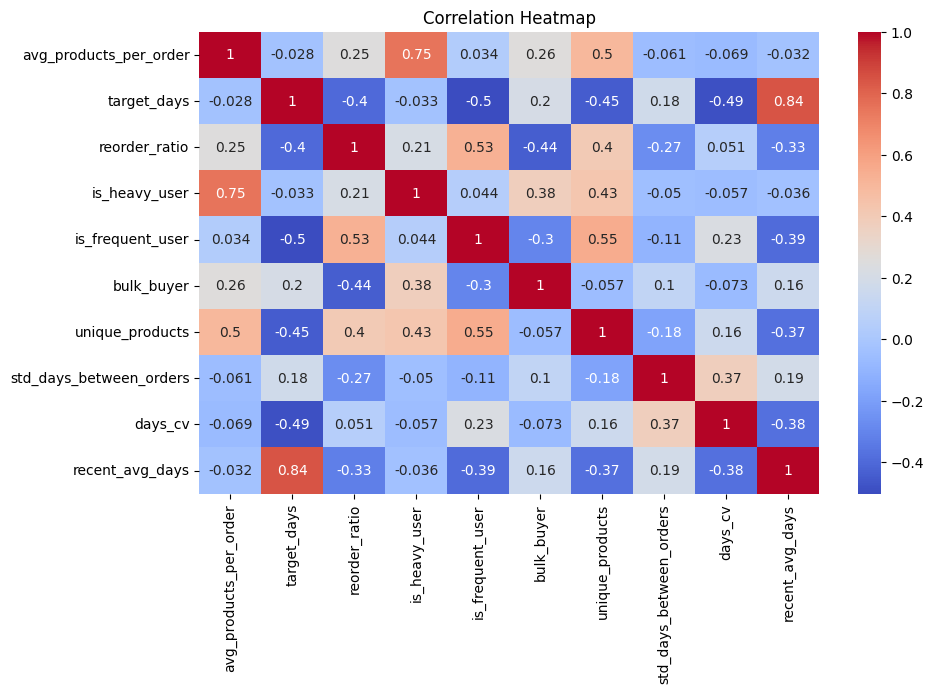

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#قياس العلاقة بين المتغيرات مع بعضها
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:

num_cols=['avg_products_per_order', 'target_days', 'reorder_ratio',
       'is_heavy_user', 'is_frequent_user', 'bulk_buyer', 'unique_products',
       'std_days_between_orders', 'days_cv', 'recent_avg_days']


In [ ]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: عدد الـ outliers = {outliers.shape[0]}")


avg_products_per_order: عدد الـ outliers = 5706
target_days: عدد الـ outliers = 0
reorder_ratio: عدد الـ outliers = 0
is_heavy_user: عدد الـ outliers = 0
is_frequent_user: عدد الـ outliers = 0
bulk_buyer: عدد الـ outliers = 42418
unique_products: عدد الـ outliers = 10975
std_days_between_orders: عدد الـ outliers = 197
days_cv: عدد الـ outliers = 7531
recent_avg_days: عدد الـ outliers = 0


In [ ]:
clip_cols = [
    "avg_products_per_order",
     "reorder_ratio",
    "target_days",
    "bulk_buyer",
    "unique_products",
    "std_days_between_orders",
    "days_cv"

]

for col in clip_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower, upper)


In [ ]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: عدد الـ outliers = {outliers.shape[0]}")


avg_products_per_order: عدد الـ outliers = 0
target_days: عدد الـ outliers = 0
reorder_ratio: عدد الـ outliers = 0
is_heavy_user: عدد الـ outliers = 0
is_frequent_user: عدد الـ outliers = 0
bulk_buyer: عدد الـ outliers = 0
unique_products: عدد الـ outliers = 0
std_days_between_orders: عدد الـ outliers = 0
days_cv: عدد الـ outliers = 0
recent_avg_days: عدد الـ outliers = 0


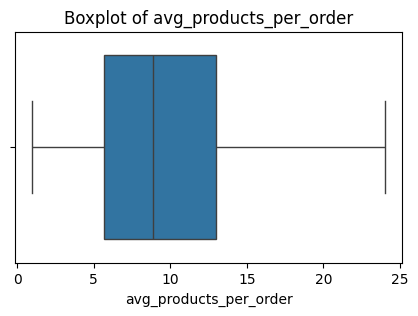

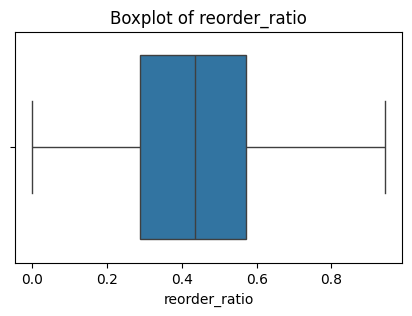

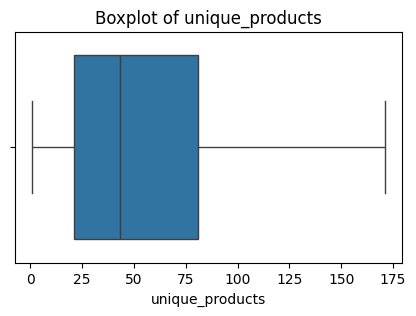

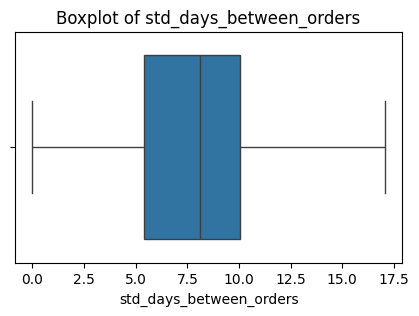

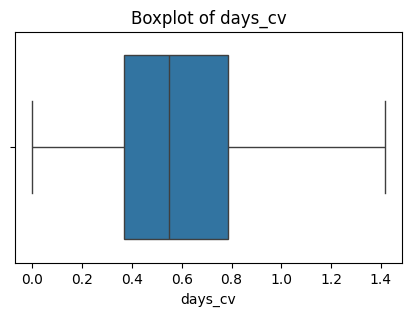

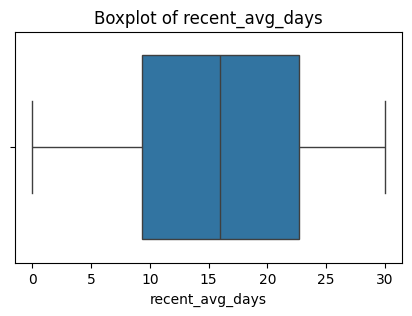

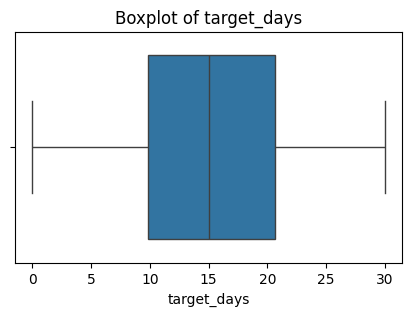

In [ ]:
for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2:", r2_score(y_test, y_pred_lr))


Linear Regression
MAE: 1.2891780447007701
RMSE: 1.6584966880003142
R2: 0.9425076194572982


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# 4. بناء النموذج الخطي المحسّن

poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Ridge = Linear Regression مع Regularization
model = Ridge(alpha=1.0)
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)


# 5. التقييم
r2_train = model.score(X_train_poly, y_train)
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("===== MODEL EVALUATION =====")
print(f"Train R²: {r2_train:.3f}")
print(f"Test  R²: {r2_test:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

===== MODEL EVALUATION =====
Train R²: 0.984
Test  R²: 0.983
MAE: 0.653
RMSE: 0.890


In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

print("Ridge Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R2:", r2_score(y_test, y_pred_ridge))


Ridge Regression
MAE: 1.2891826792578858
RMSE: 1.6584958570809296
R2: 0.9425076770655187


In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

print("Lasso Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("R2:", r2_score(y_test, y_pred_lasso))


Lasso Regression
MAE: 1.2965560677213341
RMSE: 1.6603482046700597
R2: 0.9423791808295614


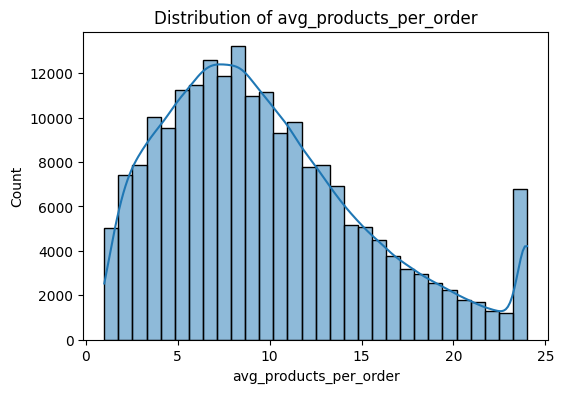

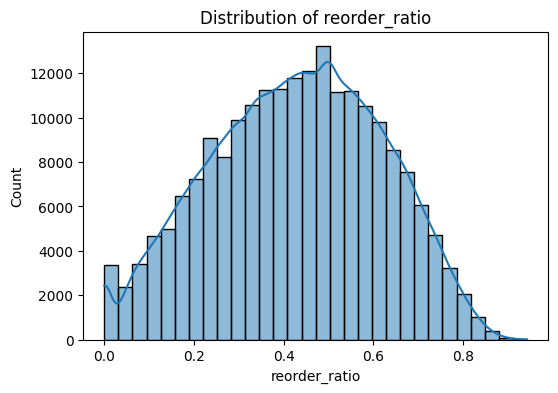

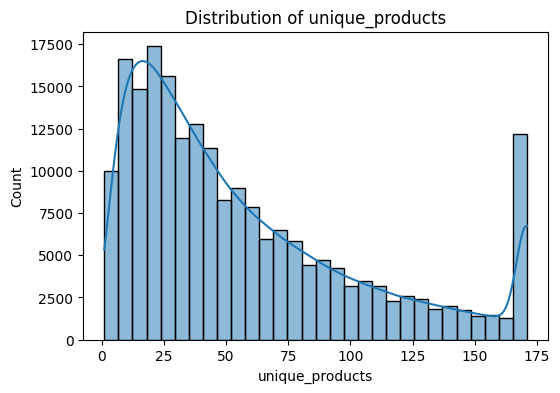

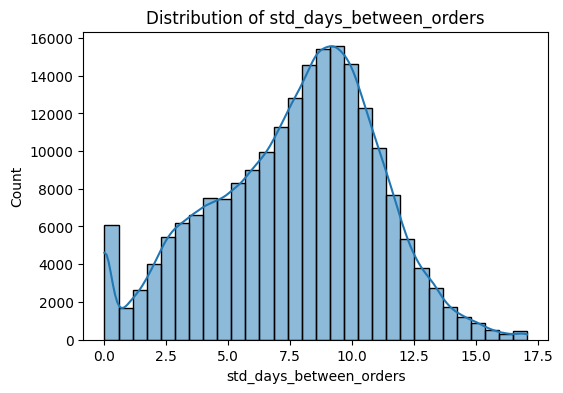

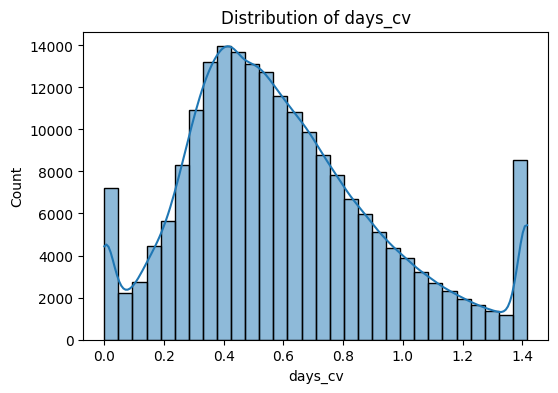

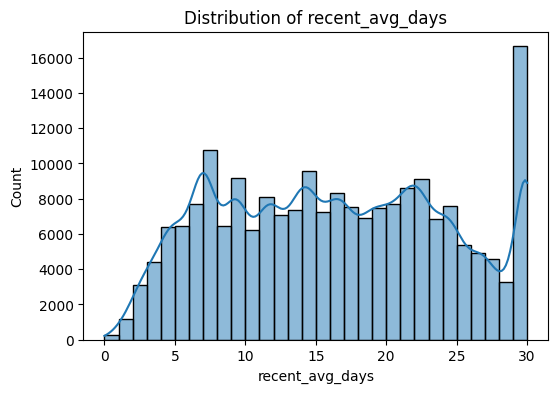

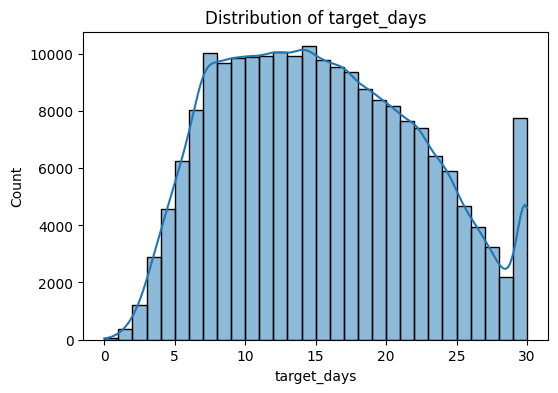

In [ ]:
#نفهم توزيع البيانات، هل هي skewed؟
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [
    'avg_products_per_order','reorder_ratio','unique_products',
    'std_days_between_orders','days_cv','recent_avg_days','target_days'
]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


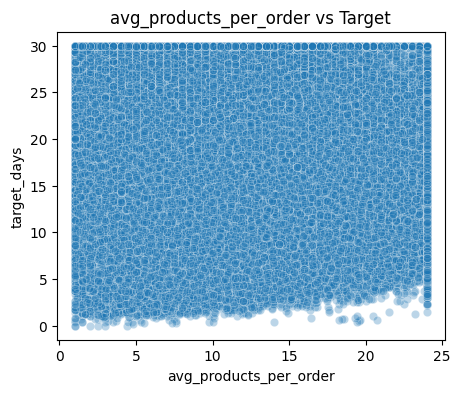

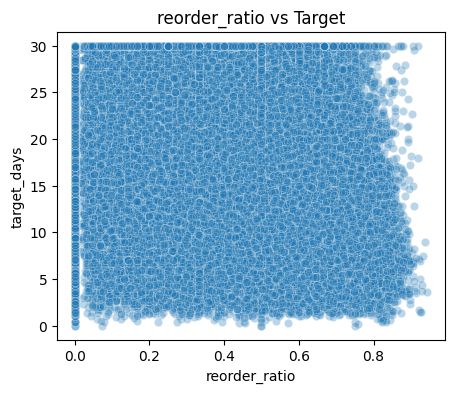

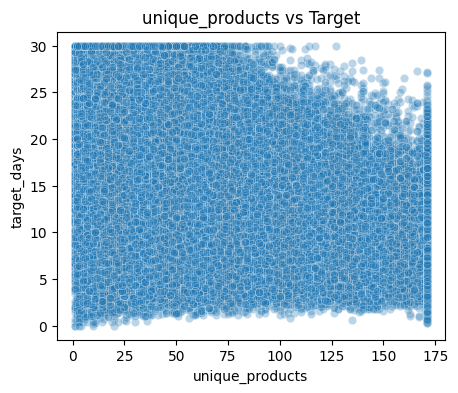

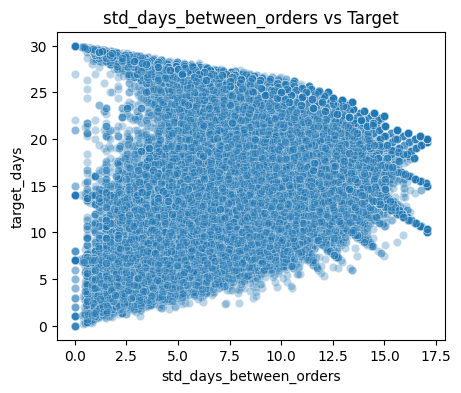

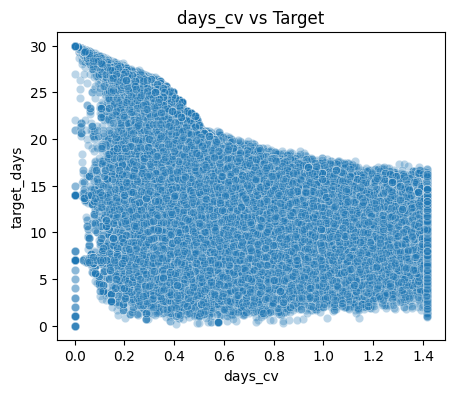

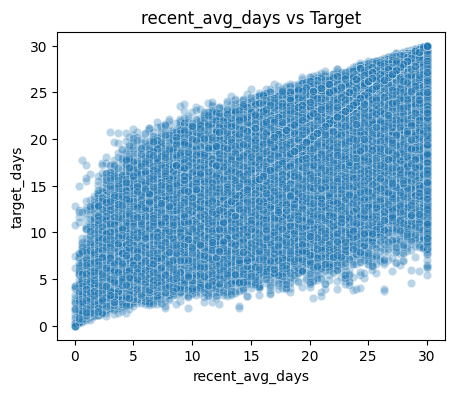

In [ ]:
for col in num_cols:
    if col != "target_days":
        plt.figure(figsize=(5,4))
        sns.scatterplot(x=df[col], y=df["target_days"], alpha=0.3)
        plt.title(f"{col} vs Target")
        plt.show()


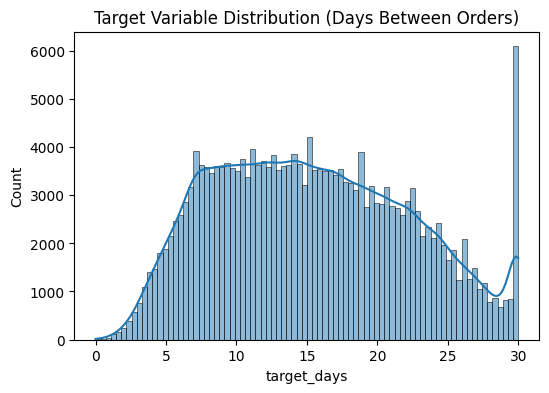

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df["target_days"], kde=True)
plt.title("Target Variable Distribution (Days Between Orders)")
plt.show()


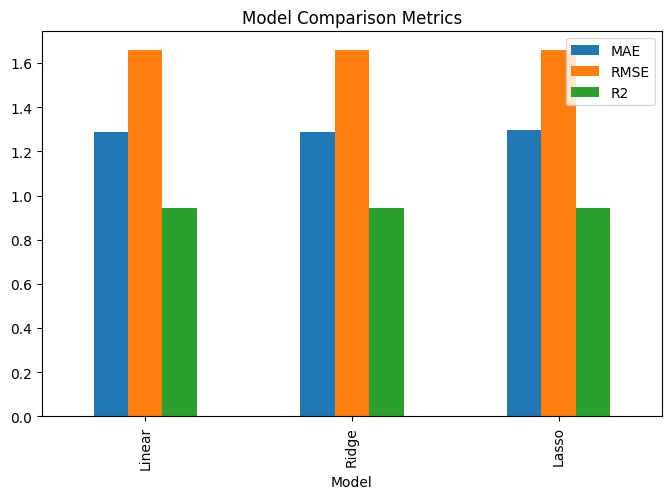

In [ ]:
models = ["Linear", "Ridge", "Lasso"]
mae_scores = [
    mean_absolute_error(y_test, y_pred_lr),
    mean_absolute_error(y_test, y_pred_ridge),
    mean_absolute_error(y_test, y_pred_lasso)
]

rmse_scores = [
    np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    np.sqrt(mean_squared_error(y_test, y_pred_lasso))
]

r2_scores = [
    r2_score(y_test, y_pred_lr),
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_lasso)
]

df_scores = pd.DataFrame({
    "Model": models,
    "MAE": mae_scores,
    "RMSE": rmse_scores,
    "R2": r2_scores
})

df_scores.set_index("Model").plot(kind="bar", figsize=(8,5))
plt.title("Model Comparison Metrics")
plt.show()


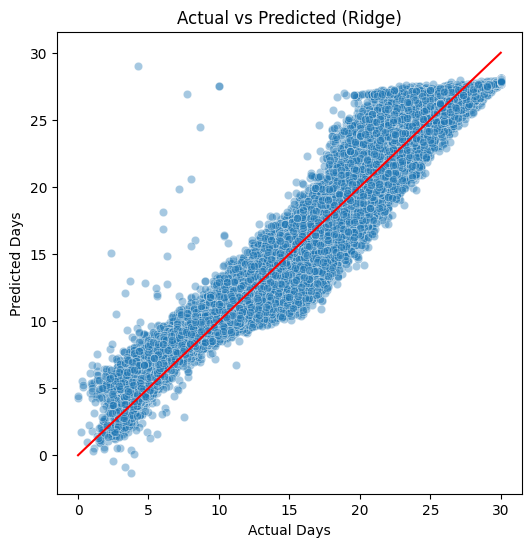

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.xlabel("Actual Days")
plt.ylabel("Predicted Days")
plt.title("Actual vs Predicted (Ridge)")
plt.show()
#الخط الاحمر هو الprediction